<a href="https://colab.research.google.com/github/joebathelt/AUC_CogPsy/blob/main/MindReading_Week6_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nilearn

# Preprocessing Functional Data

In the lecture, we discussed how fMRI data are collected and how the BOLD signal reflects neural activity. Before we can analyse this signal statistically, however, the raw data must undergo several **preprocessing** steps.

The reason is straightforward: the BOLD signal is *very noisy*. Task-related activation typically accounts for only 2–5% of the total variance in the measured signal. The rest comes from head motion, scanner imperfections, physiological noise (breathing, heartbeat), and other sources unrelated to the experiment. If these nuisance sources are not addressed, they can obscure real effects or produce spurious ones.

Preprocessing does not change the experimental design or the hypotheses being tested. Rather, it reduces unwanted sources of variance so that the subsequent statistical analysis — such as the General Linear Model — has the best possible chance of detecting genuine task-related activity.

By the end of this session, you should be able to:

1. Explain what each preprocessing step does and why it is necessary.
2. Navigate a dataset organised in the Brain Imaging Data Structure (BIDS).
3. Interpret quality-control reports from an automated preprocessing pipeline.
4. Describe the trade-offs involved in spatial smoothing.

---
**Expected time to complete**: ~90 minutes

In [ ]:
# Setup: import libraries and download required data files

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from nibabel.affines import apply_affine, from_matvec, to_matvec
from scipy.ndimage import affine_transform, map_coordinates
import nibabel as nib
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
from IPython.display import display
import os

from scipy.interpolate import interp1d
from nilearn.image.image import mean_img
from nilearn.plotting import plot_epi
import pandas as pd

In [ ]:
import os
import urllib.request

def download_file(url, outfile):
    """Download file from URL if not already present."""
    if not os.path.exists(outfile):
        print(f"Downloading {outfile}...")
        urllib.request.urlretrieve(url, outfile)
        print(f"Saved as {outfile}")
    else:
        print(f"{outfile} already exists, skipping download.")

# Download required data files
for url, name in zip([
        "https://www.dropbox.com/scl/fi/s88scelnqsngdjkqo5wzc/motion_effect.gif?rlkey=8g0xuc3ba2hyerdvr3if79x2j&dl=1",
        "https://www.dropbox.com/scl/fi/l20txfo2wm3hdedmc6gls/func_ref.nii.gz?rlkey=npwweciiwdeak0knc9hx4eaf3&dl=1",
        "https://www.dropbox.com/scl/fi/zji5axwbtrkgoxvvviwgh/fd_before.txt?rlkey=17qchey8a1hh1go5tnacdto3q&dl=1",
        "https://www.dropbox.com/scl/fi/km4wke2r5atznd0rmgdav/fd_after.txt?rlkey=m805jxby8s5ef76w538srw9x2&dl=1",
        "https://www.dropbox.com/scl/fi/lwvqxktn4owjvwih6io17/figure_fMRIPrep_movement.png?rlkey=kzy8adr6rf9a61bph3dav8kcp&dl=1",
        "https://www.dropbox.com/scl/fi/t37kcc5vfbt41vuye69zj/figure_fMRIPrep_movement_a.png?rlkey=rf5yaff5xn1z04k36hw6djqj5&dl=1",
        "https://www.dropbox.com/scl/fi/0n8gbsdnjmqdhg1qfhlih/figure_fMRIPrep_movement_b.png?rlkey=aarhfxmgem3ube2i2tnanaxwe&dl=1",
        "https://www.dropbox.com/scl/fi/4alju61i0cq6dbj7s3eln/figure_susceptibility_illustration.png?rlkey=x6u9e6jeslurrwxeql5fvxbn5&dl=1",
        "https://www.dropbox.com/scl/fi/ibg4r3iz19vaavt9cqog4/figure_fMRIPrep_fieldmap.png?rlkey=28b26bt0pglaatk88s954b72u&dl=1",
        "https://www.dropbox.com/scl/fi/8x1koxtvvdskn9ifea706/figure_T1vsEPI.png?rlkey=pyxqpdmuy8bqbroeiy1eqj97p&dl=1",
        "https://www.dropbox.com/scl/fi/yc6jwneiougdgm95a7q0x/figure_anatomy_comparison.png?rlkey=amlqs8hhvram8rjoee1gk0qn7&dl=1",
        "https://www.dropbox.com/scl/fi/4jp6gk1ff870v752hiocf/sub-03_ses-1_task-face_run-1_space-T1w_boldref.nii.gz?rlkey=8u21e61jnmghgx3qfsskqja86&dl=1",
        "https://www.dropbox.com/scl/fi/ybcoqc8skoaufguqocl1w/sub-03_ses-1_acq-AxialNsig2Mm1_desc-preproc_T1w.nii.gz?rlkey=2fq2639beaurl9ubz3y5a5g6g&dl=1"
    ],
    [
        "motion_effect.gif",
        "func_ref.nii.gz",
        "fd_before.txt",
        "fd_after.txt",
        "figure_fMRIPrep_movement.png",
        "figure_fMRIPrep_movement_a.png",
        "figure_fMRIPrep_movement_b.png",
        "figure_susceptibility_illustration.png",
        "figure_fMRIPrep_fieldmap.png",
        "figure_T1vsEPI.png",
        "figure_anatomy_comparison.png",
        "sub-03_ses-1_task-face_run-1_space-T1w_boldref.nii.gz",
        "sub-03_ses-1_acq-AxialNsig2Mm1_desc-preproc_T1w.nii.gz"
    ]):

    download_file(url, name)

motion_effect.gif already exists, skipping download.
func_ref.nii.gz already exists, skipping download.
Saved as fd_before.txt
Saved as fd_after.txt
figure_fMRIPrep_movement.png already exists, skipping download.
figure_fMRIPrep_movement_a.png already exists, skipping download.
figure_fMRIPrep_movement_b.png already exists, skipping download.
figure_susceptibility_illustration.png already exists, skipping download.
figure_fMRIPrep_fieldmap.png already exists, skipping download.
figure_T1vsEPI.png already exists, skipping download.
figure_anatomy_comparison.png already exists, skipping download.
sub-03_ses-1_task-face_run-1_space-T1w_boldref.nii.gz already exists, skipping download.
sub-03_ses-1_acq-AxialNsig2Mm1_desc-preproc_T1w.nii.gz already exists, skipping download.


## 1. Brain Imaging Data Structure (BIDS)

In the early days of neuroimaging, each laboratory — and often each individual researcher — had their own system for organising data. This made it difficult to reuse datasets or to develop software that worked seamlessly across studies.

The **Brain Imaging Data Structure (BIDS)** was introduced to address this problem. BIDS defines a standardised system for how neuroimaging data should be organised and documented. It has since become the accepted standard across the field.

### Key features of BIDS

**Folder structure.** A BIDS dataset lives in a single directory. The top level contains files such as `dataset_description.json` (metadata about the dataset). Each participant has a folder named `sub-<participant_id>` with subfolders for different modalities — for example, `anat/` for anatomical images and `func/` for functional images.

**File naming.** Consistent naming conventions make it immediately clear what each file contains. For example, the file `sub-01_task-rest_bold.nii.gz` indicates participant 01, resting-state task, BOLD fMRI data.

**Metadata.** Acquisition parameters and task conditions are stored in `.json` sidecar files alongside the imaging data. This ensures analyses are reproducible and data can be shared without needing to consult the original authors.

**BIDS Validator.** An online tool that checks whether a dataset follows the BIDS standard, reporting errors and warnings.

### BIDS Apps

Once data are organised in BIDS format, they can be processed using **BIDS Apps** — containerised software packages designed for neuroimaging. Because they use technologies such as Docker, BIDS Apps work on any system with minimal setup.

The most widely used example is **fMRIPrep**, a robust pipeline for fMRI preprocessing. We will not run fMRIPrep in this session (it requires substantial computing time), but in the sections that follow we will examine each of the preprocessing steps it performs.

### Exploring a BIDS dataset

To get a sense of what a BIDS dataset looks like in practice, open the following link and browse through the structure:

**[OpenNeuro: ds003965 (version 1.0.0)](https://openneuro.org/datasets/ds003965/versions/1.0.0)**

At the top level, look for files such as `dataset_description.json`, `README`, and `participants.tsv`. Inside participant folders (e.g., `sub-03/`), explore the `anat/` and `func/` subdirectories. Notice how every file follows a consistent naming convention: `sub-03_ses-1_task-flocBLOCKED_bold.nii.gz` tells you the participant, session, task, and data type at a glance.

The `events.tsv` files are particularly important — they describe what happened during the experiment (onset times, durations, trial types). These files are what we will later use to build predictors for the GLM.

## 2. Overview of Preprocessing Steps

Preprocessing fMRI data involves a series of signal cleaning and alignment steps that prepare the data for statistical analysis. The most common steps are:

1. **Skull stripping** — removing non-brain tissue
2. **Motion correction (realignment)** — correcting for head movement
3. **Susceptibility distortion correction** — compensating for magnetic field inhomogeneities
4. **Slice timing correction** — adjusting for differences in slice acquisition time
5. **Coregistration** — aligning functional and anatomical images
6. **Normalisation** — mapping data into a standard anatomical space
7. **Spatial smoothing** — averaging signal across neighbouring voxels

High-resolution anatomical scans (T1- or T2-weighted) are typically acquired in the same session as the functional data and are essential for several of these steps — particularly for creating brain masks, guiding alignment, and defining the transformation to standard space.

The figure below illustrates the major preprocessing steps as implemented in fMRIPrep. We will examine the fMRI-specific steps (right side of the diagram) in the sections that follow.

![Overview](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41592-018-0235-4/MediaObjects/41592_2018_235_Fig1_HTML.png)

*Image source: [Esteban et al., 2019](https://doi.org/10.1038/s41592-018-0235-4)*

## 3. Skull Stripping

Functional images are typically acquired together with the skull and other non-brain tissue. Since these regions carry no useful BOLD signal, they are removed using a **brain mask** — a process known as skull stripping.

The mask is usually created from the high-resolution anatomical scan and then applied to the functional images. The quality of skull stripping affects all subsequent steps, so it is important to verify that the mask fits well. In this notebook, we will assume skull stripping has already been performed.

## 4. Motion Correction (Realignment)

Participants inevitably move their heads during scanning — even "well-behaved" subjects. This motion introduces artefacts that can substantially affect the BOLD signal.

The animation below shows a participant's head moving subtly between frames, illustrating why motion correction is necessary.

![Motion Illustration](motion_effect.gif)

Motion correction works by selecting a **reference volume** (usually the first or middle one) and then aligning all other volumes to match it. This is achieved through two types of geometric transformations:

- **Translation** — shifts along the X, Y, and Z axes (left/right, up/down, front/back)
- **Rotation** — rotations around the three axes (pitch, roll, yaw)

![pitchrollyaw](https://www.researchgate.net/profile/Tsang_Ing_Ren/publication/279291928/figure/fig1/AS:292533185462272@1446756754388/Orientation-of-the-head-in-terms-of-pitch-roll-and-yaw-movements-describing-the-three.png)

*Image from [Arcoverde Neto et al., 2014](https://www.researchgate.net/figure/Orientation-of-the-head-in-terms-of-pitch-roll-and-yaw-movements-describing-the-three_fig1_279291928)*

These six parameters (three translations and three rotations) define a **rigid body transformation** — one that moves and rotates the image without changing its shape. This is appropriate because a person's brain does not change shape during a scan; only its position in the scanner changes.

The correct transformation is found by an **optimisation algorithm** that iteratively adjusts the six parameters until a **cost function** (measuring the difference between the moving image and the reference) is minimised.

### Interactive demo: 2D image alignment

The widget below illustrates the principle in 2D. The "moving image" has been shifted by a random amount. Use the sliders to translate it until it aligns with the reference image, and observe how the cost function (sum of squared errors) decreases as alignment improves.

In practice, the optimisation algorithm performs this search automatically — and in 3D, with rotations included.

In [ ]:
%matplotlib inline

import os
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
import nibabel as nib
from ipywidgets import interact, FloatSlider

def build_translation_affine_2d(trans_x: float, trans_y: float) -> np.ndarray:
    A = np.array([[1.0, 0.0, float(trans_y)],
                  [0.0, 1.0, float(trans_x)],
                  [0.0, 0.0, 1.0]], dtype=float)
    return A

def apply_affine_coords_2d(A, coords_last):
    H, W, _ = coords_last.shape
    ones = np.ones((H, W, 1), dtype=float)
    homo = np.concatenate([coords_last.astype(float), ones], axis=-1)
    flat = homo.reshape(-1, 3).T
    out = (A @ flat).T[:, :2]
    return out.reshape(H, W, 2)

def warp_image_2d(image, A, order=1, cval=0.0):
    H, W = image.shape
    i_coords, j_coords = np.meshgrid(np.arange(H), np.arange(W), indexing="ij")
    grid_ij = np.stack([i_coords, j_coords], axis=-1)
    src_ij = apply_affine_coords_2d(A, grid_ij)
    coords_for_map = np.stack([src_ij[..., 0], src_ij[..., 1]], axis=0)
    return map_coordinates(image, coords_for_map, order=order, mode="constant", cval=cval)

def apply_initial_translation(mri_slice, trans_x, trans_y):
    A = build_translation_affine_2d(trans_x=trans_x, trans_y=trans_y)
    return warp_image_2d(mri_slice, A, order=1, cval=0.0)

def plot_affine_cost(mri_slice1, mri_slice2, trans_x=0, trans_y=0):
    A = build_translation_affine_2d(trans_x=trans_x, trans_y=trans_y)
    transformed_slice = warp_image_2d(mri_slice1, A, order=1, cval=0.0)

    f, a = plt.subplots(ncols=3, figsize=(15, 5))
    a[0].imshow(transformed_slice, cmap='gray')
    a[0].set_xlabel('x', fontsize=16)
    a[0].set_ylabel('y', fontsize=16)
    a[0].set_title('Moving Image (transformed)', fontsize=18)

    a[1].imshow(mri_slice2, cmap='gray')
    a[1].set_xlabel('x', fontsize=16)
    a[1].set_ylabel('y', fontsize=16)
    a[1].set_title('Reference Image', fontsize=18)

    sse = float(np.sum((transformed_slice - mri_slice2) ** 2))
    a[2].bar(0, sse)
    a[2].set_ylim([0, max(1.0, sse * 1.1)])
    a[2].set_ylabel('SSE', fontsize=18)
    a[2].set_xlabel('Cost Function', fontsize=18)
    a[2].set_xticks([])
    a[2].set_title(f'Parameters: (tx={int(trans_x)}, ty={int(trans_y)})', fontsize=16)
    plt.tight_layout()
    plt.show()

# Load an example NIfTI and extract a 2D slice
img = nib.load(os.path.abspath('func_ref.nii.gz'))
mri_slice = img.get_fdata()[40, ...]
mri_slice1 = np.flipud(mri_slice.T)
mri_slice2 = np.flipud(mri_slice.T)

# Create an initially misaligned moving image
rng = np.random.default_rng()
initial_trans_x = int(rng.integers(-5, 6))
initial_trans_y = int(rng.integers(-5, 6))
mri_slice1_translated = apply_initial_translation(mri_slice1, initial_trans_x, initial_trans_y)

def interactive_plot(trans_x, trans_y):
    plot_affine_cost(mri_slice1_translated, mri_slice2, trans_x, trans_y)

interact(
    interactive_plot,
    trans_x=FloatSlider(value=0, min=-30, max=30, step=1, description="tx (cols)"),
    trans_y=FloatSlider(value=0, min=-30, max=30, step=1, description="ty (rows)")
)

interactive(children=(FloatSlider(value=0.0, description='tx (cols)', max=30.0, min=-30.0, step=1.0), FloatSli…

<function __main__.interactive_plot(trans_x, trans_y)>

### Evaluating motion: Framewise Displacement

The cost function itself is not informative in absolute terms — its values depend on image intensities, which differ between participants and sessions. A more useful summary of head motion is **framewise displacement (FD)**.

FD is calculated as the sum of the absolute changes in the six motion parameters between consecutive volumes. Rotations are converted to millimetres (by projecting them onto the surface of a sphere of ~50 mm radius), so all parameters are in comparable units. High FD values indicate substantial head movement.

The plot below compares FD before and after motion correction for one participant.

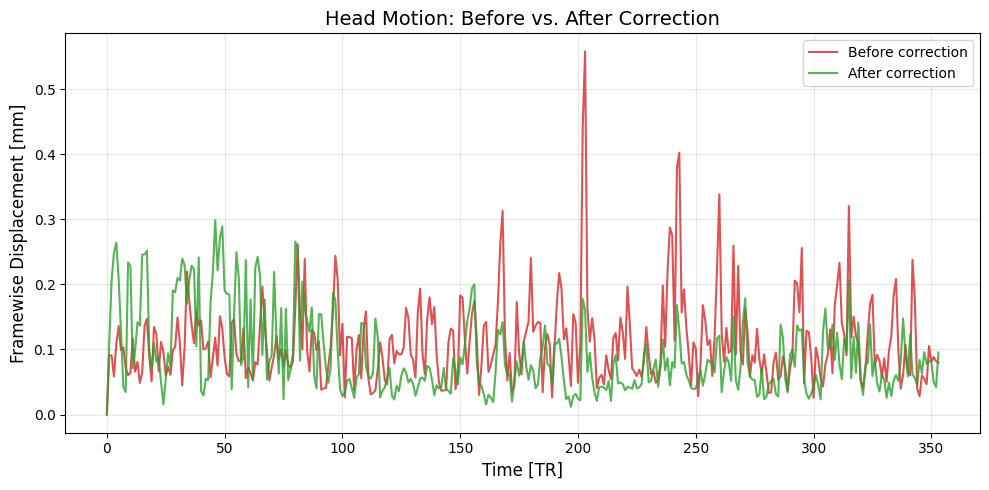

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load framewise displacement (FD) values
fd_before = np.loadtxt(os.path.abspath('fd_before.txt'))
fd_after = np.loadtxt(os.path.abspath('fd_after.txt'))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(fd_before, label='Before correction', color='tab:red', alpha=0.8)
plt.plot(fd_after, label='After correction', color='tab:green', alpha=0.8)

plt.xlabel('Time [TR]', fontsize=12)
plt.ylabel('Framewise Displacement [mm]', fontsize=12)
plt.title('Head Motion: Before vs. After Correction', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

As the plot shows, the major spike is largely eliminated after motion correction. You might notice, however, that the early time points appear to show *more* movement after correction. This is not because correction introduced motion — it reflects the fact that all volumes are aligned to a single reference. If the participant's head drifted gradually, volumes far from the reference position require larger adjustments.

Motion correction is effective but not perfect. If a participant moves excessively, some scans may need to be excluded. Even after correction, residual motion effects often remain, which is why the estimated motion parameters are typically included as **confound regressors** in the statistical model.

### fMRIPrep motion reports

fMRIPrep produces a detailed quality-control report for each dataset. The figure below shows a key excerpt.

![fMRIPrep Movement Report](figure_fMRIPrep_movement.png)

The report provides several useful diagnostics:

- **Top traces** show the average time series for global signal (GS), cerebrospinal fluid (CSF), and white matter (WM). Since these regions should not contain meaningful BOLD-related activity, fluctuations in these signals typically reflect noise.
- **Middle traces** show framewise displacement (FD) and DVARS (the root mean square of temporal signal derivatives). Both are indicators of sudden head movement.
- **Carpet plot** (bottom) displays voxel time series from different brain structures stacked together. Vertical stripes running across all structures are a hallmark of motion artefacts.

For more details on interpreting carpet plots, see [Power, 2022](https://doi.org/10.3389/fnimg.2022.1073734).

## 5. Susceptibility Distortion Correction

The BOLD signal is influenced by the magnetic field of the scanner. Because this field is never perfectly uniform, it produces **geometric distortions** — regions of the image are stretched or compressed. These artefacts are especially pronounced in areas near air-tissue boundaries, such as the **frontal lobes** and **temporal lobes**.

### How is this corrected?

Several approaches exist, but all require additional images beyond the main functional run. The most common method acquires a short set of volumes with the **opposite phase-encoding direction**. For example, if the main fMRI run is acquired anterior-to-posterior, a few volumes are also acquired posterior-to-anterior. The distortions are opposite in the two directions, which makes it possible to estimate and correct them.

![encoding_directions](figure_susceptibility_illustration.png)

The example below shows a **fieldmap** — a map of where the image needs to be shifted to correct the distortion. Red and blue indicate shifts in opposite directions along the phase-encoding axis.

![fieldmap](figure_fMRIPrep_fieldmap.png)

After correction, the functional images should align more closely with the anatomy. When assessing data quality, it is always worth comparing images before and after this step. If the correction fails — for example, due to excessive motion or incorrect metadata — residual distortions may remain, and the dataset may need to be excluded.

We will not cover the physics or algorithms of distortion correction in detail, but it is important to be able to **recognise** susceptibility distortions and understand what the correction achieves.

## 6. Slice Timing Correction

In fMRI, the brain is scanned one **slice** at a time. Because slices are acquired sequentially, each one is captured at a slightly different time point within the same TR. This creates a temporal misalignment: some slices are recorded earlier, others later.

**Slice timing correction** adjusts the data so that all slices are aligned in time, as if they had been acquired simultaneously.

To illustrate this, the code below simulates time courses from two voxels in different slices. The red voxel (bottom of the brain) was acquired at a different time within each TR than the blue voxel (top of the brain).

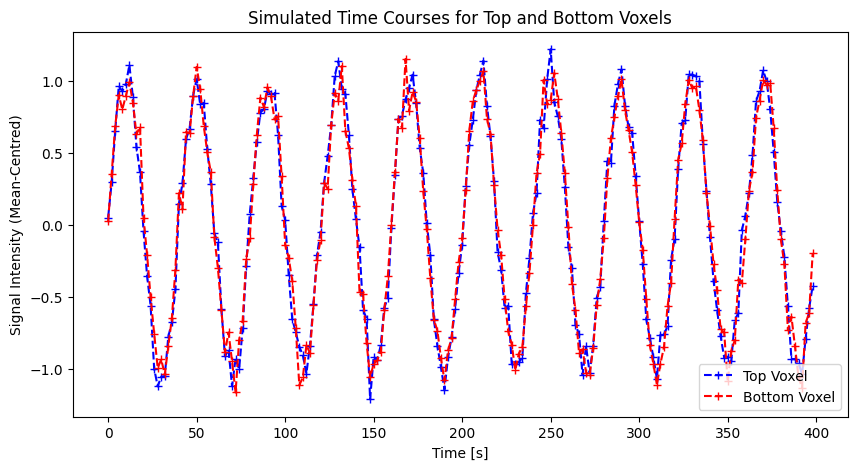

In [ ]:
# Simulation: voxels from different slices are acquired at different times

n_timepoints = 200
TR = 2.0            # Repetition time in seconds
np.random.seed(42)
slice_times = np.arange(0, n_timepoints * TR, TR)

def simulate_time_course(n_timepoints, frequency=0.05, noise_level=0.1):
    time = np.arange(n_timepoints)
    time_course = np.sin(2 * np.pi * frequency * time) + noise_level * np.random.randn(n_timepoints)
    time_course = time_course - np.mean(time_course)
    return time_course

time_courses = []
for name in ['top', 'bottom']:
    time_course = simulate_time_course(n_timepoints)
    time_courses.append({'name': name, 'time_course': time_course})

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(slice_times, time_courses[0]['time_course'], label='Top Voxel', color='blue', linestyle='--', marker='+')
ax.plot(slice_times, time_courses[1]['time_course'], label='Bottom Voxel', color='red', linestyle='--', marker='+')
ax.set_title('Simulated Time Courses for Top and Bottom Voxels')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Signal Intensity (Mean-Centred)')
ax.legend()
plt.show()

When we account for the actual acquisition times, we can see that the signals are slightly offset in time. The vertical lines below indicate the times at which the bottom voxel was acquired.

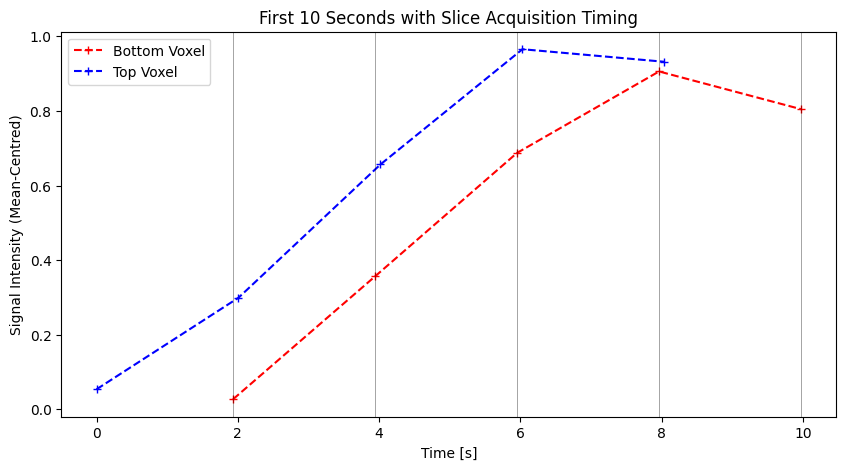

In [ ]:
# Show the temporal offset between slices

n_z_slices = 30
time_for_single_slice = TR / n_z_slices

slice_times_lin = np.linspace(0, n_timepoints * TR, n_timepoints)
slice_times_bottom = slice_times_lin[:5] + (n_z_slices - 1) * time_for_single_slice
slice_times_top = slice_times_lin[:5] + 0 * time_for_single_slice

plt.figure(figsize=(10, 5))
plt.plot(slice_times_bottom, time_courses[1]['time_course'][:5], label='Bottom Voxel', color='red', linestyle='--', marker='+')
plt.plot(slice_times_top, time_courses[0]['time_course'][:5], label='Top Voxel', color='blue', linestyle='--', marker='+')
plt.xlabel('Time [s]')
plt.ylabel('Signal Intensity (Mean-Centred)')
plt.legend()

for slice_time in slice_times_bottom:
    plt.axvline(slice_time, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

plt.title('First 10 Seconds with Slice Acquisition Timing')
plt.show()

### How does slice timing correction work?

The solution is **temporal interpolation**: we estimate what the signal would have been if all slices had been acquired at exactly the same time. This is done by fitting a function (such as a linear or spline interpolation) through the observed data points and evaluating it at the desired reference time.

The code below demonstrates this using linear interpolation from SciPy. After correction, both voxels' time courses are expressed at the same set of time points.

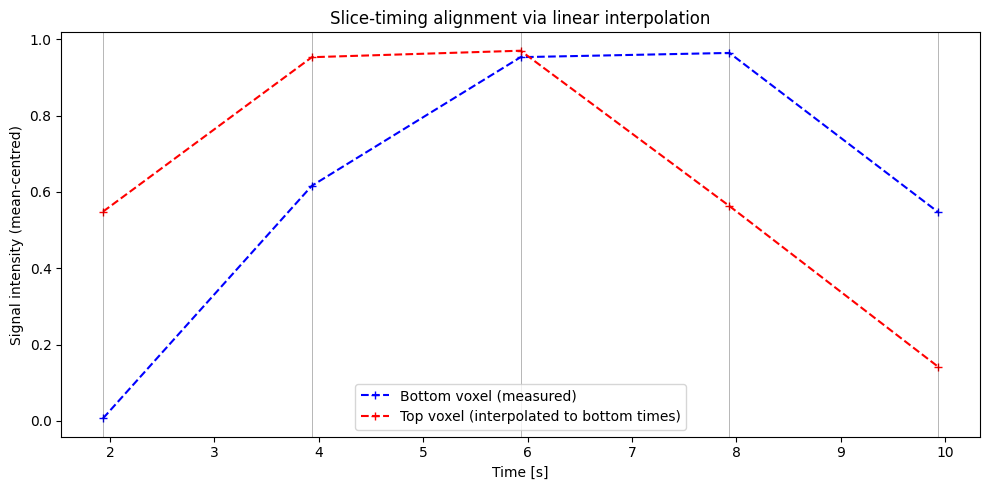

In [ ]:
# Slice-timing correction demo: align "top" voxel to "bottom" voxel times via interpolation

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

n_timepoints   = 200
TR             = 2.0
n_z_slices     = 30
dt_slice       = TR / n_z_slices

t_window       = 10.0
n_pts_window   = int(t_window / TR)

t_tr           = np.arange(n_timepoints) * TR
t_top          = t_tr[:n_pts_window] + 0 * dt_slice
t_bottom       = t_tr[:n_pts_window] + (n_z_slices - 1) * dt_slice

rng = np.random.default_rng(42)
true_signal    = np.sin(2 * np.pi * (t_tr / 20.0))
top_signal     = true_signal + 0.02 * rng.standard_normal(t_tr.shape)
bottom_signal  = true_signal + 0.02 * rng.standard_normal(t_tr.shape)

y_top_window     = top_signal[:n_pts_window]
y_bottom_window  = bottom_signal[:n_pts_window]

# Interpolate the top voxel to the acquisition times of the bottom voxel
top_to_bottom = interp1d(t_top, y_top_window, kind="linear",
                         bounds_error=False, fill_value="extrapolate")
y_top_interp_at_bottom = top_to_bottom(t_bottom)

plt.figure(figsize=(10, 5))
plt.plot(t_bottom, y_bottom_window, label='Bottom voxel (measured)', linestyle='--', marker='+', color='blue')
plt.plot(t_bottom, y_top_interp_at_bottom, label='Top voxel (interpolated to bottom times)', linestyle='--', marker='+', color='red')

for tb in t_bottom:
    plt.axvline(tb, color='k', linestyle='-', linewidth=0.5, alpha=0.4)

plt.xlabel('Time [s]')
plt.ylabel('Signal intensity (mean-centred)')
plt.title('Slice-timing alignment via linear interpolation')
plt.legend()
plt.tight_layout()
plt.show()

In practice, slice timing correction is performed automatically by fMRIPrep if the necessary metadata are available. However, this step is more **error-prone** than many others: if the slice timing information in the metadata does not match the actual acquisition protocol, the correction will introduce errors rather than fix them. These errors are difficult to detect by visual inspection alone.

**Always verify** that the slice timing information in your BIDS metadata matches the protocol file from the scanner.

## 7. Coregistration

In most fMRI studies, we acquire high-resolution anatomical images (T1-weighted and/or T2-weighted) during the same session as the functional scans. These images capture fine structural detail and can be used to define brain regions of interest.

To take advantage of this information, the functional images must be **aligned with the anatomical images** — a step called coregistration. The figure below shows the same participant's anatomy and functional image side by side, illustrating the difference in resolution and contrast.

!['T1w versus EPI'](figure_T1vsEPI.png)

Coregistration uses the same principle as motion correction — an optimisation algorithm iteratively adjusts an affine transformation until the functional image best matches the anatomy. However, because the two image types have very different contrast (bright regions in a T1 image are not necessarily bright in a BOLD image), a different **cost function** is needed. The standard choice is **mutual information (MI)**, which measures the statistical dependence between the intensity distributions of the two images and works well even when the relationship between intensities is nonlinear.

## 8. Normalisation

The final alignment step is **normalisation** — transforming each participant's brain into a **common reference space**. Without this step, the same voxel coordinates would refer to different anatomical locations in different participants, making group comparisons meaningless.

The figure below illustrates this: the same voxel coordinate points to different brain regions across participants. In one case, it falls outside the brain entirely.

!['Anatomy Comparison'](figure_anatomy_comparison.png)

### The MNI152 space

The most widely used reference template is the **MNI152 space**, based on an average of 152 anatomical scans. Several variants exist (e.g., MNI152NLin2009cAsym, the default in fMRIPrep). For analysis, the exact variant matters less than ensuring all participants are transformed to the **same space**. For reporting, however, it is important to state which template was used.

### Non-linear transformation

Unlike motion correction and coregistration (which use rigid or affine transformations), normalisation typically requires a **non-linear transformation**. Human brains vary not only in position and overall size, but in the shape of individual folds and structures. Non-linear transformations allow for local stretching and compression to bring each participant's anatomy into alignment with the template.

In practice, the participant's anatomical image is first aligned to the MNI template. The resulting transformation is then applied to the functional images, bringing all data into the same coordinate space.

Normalisation is typically performed on **skull-stripped images**: including non-brain tissue (skull, scalp, neck) would mislead the registration algorithm, because these structures vary greatly across individuals and do not align consistently.

## 9. Spatial Smoothing

Even after careful preprocessing, small misalignments often remain between participants' brain images. **Spatial smoothing** reduces their impact by averaging the signal across neighbouring voxels.

Smoothing is performed with a **Gaussian kernel**, whose size is described by its **full width at half maximum (FWHM)** in millimetres. A larger FWHM means more averaging — and more blurring.

The interactive demo below lets you explore the effect of different smoothing levels on a functional image.

In [ ]:
# Interactive spatial smoothing demo

import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import image
import ipywidgets as widgets

func_filename = os.path.abspath('sub-03_ses-1_task-face_run-1_space-T1w_boldref.nii.gz')
func_img = image.load_img(func_filename)

def mid_axial_slice(np3d):
    x, y, z = np3d.shape
    sl = z // 2
    return np.flipud(np3d[:, :, sl].T)

def update_plot(fwhm):
    func_smoothed = image.smooth_img(func_img, fwhm=fwhm) if fwhm > 0 else func_img
    orig_slice = mid_axial_slice(func_img.get_fdata())
    smooth_slice = mid_axial_slice(func_smoothed.get_fdata())

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(orig_slice, cmap='gray')
    plt.title('Functional Image (original)')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(smooth_slice, cmap='gray')
    plt.title(f'Functional Image (smoothed, FWHM = {fwhm:.1f} mm)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

sigma_slider = widgets.FloatSlider(
    value=2.0, min=0.0, max=10.0, step=0.1,
    description='FWHM (mm):', continuous_update=True
)

widgets.interactive(update_plot, fwhm=sigma_slider)

ModuleNotFoundError: No module named 'nibabel'

### The smoothing trade-off

Spatial smoothing involves a fundamental trade-off between **sensitivity** and **spatial specificity**.

On the one hand, averaging across neighbouring voxels reduces random noise, which makes it easier to detect genuine effects — the signal-to-noise ratio improves. On the other hand, smoothing also blurs the spatial pattern of activation: a small, well-localised effect may spread into surrounding voxels, making it harder to pinpoint exactly *where* the activity originated. In extreme cases, genuine signal from one region can "spill over" into adjacent regions that are not truly active.

There is no single correct FWHM for all analyses. Common choices in the literature range from about 4 to 8 mm, depending on the research question. Analyses that prioritise precise localisation (e.g., studying individual cortical columns or small subcortical nuclei) use little or no smoothing, while group-level analyses focused on detecting reliable effects often use moderate smoothing.

The key insight is that preprocessing choices such as smoothing are not neutral — they shape the data that enters the statistical model and therefore influence the conclusions drawn from an analysis.

### Summary of preprocessing steps

The preprocessing pipeline we have examined consists of several complementary steps, each targeting a different source of noise or misalignment:

| Step | Purpose |
|---|---|
| Skull stripping | Remove non-brain tissue |
| Motion correction | Align volumes to correct for head movement |
| Susceptibility distortion correction | Correct geometric distortions from field inhomogeneities |
| Slice timing correction | Adjust for within-TR differences in slice acquisition time |
| Coregistration | Align functional images to the anatomical image |
| Normalisation | Transform all participants into a common reference space |
| Spatial smoothing | Reduce noise by averaging neighbouring voxels |

Together, these steps ensure that the BOLD signal entering the statistical model is as clean, comparable, and interpretable as possible.

# Final Exercises

Now it is your turn. The exercises below ask you to apply concepts from Part 1. For each exercise, provide both your code (where applicable) and a brief written explanation of your reasoning.

## Exercise 1: Navigating a BIDS Dataset

Open the BIDS dataset on OpenNeuro: [ds003965 (version 1.0.0)](https://openneuro.org/datasets/ds003965/versions/1.0.0)

Browse through the dataset and answer the following questions:

**a)** What is the relative path of the **flocBLOCKED** functional data file for participant `sub-03` in session 1?

**b)** What is the relative path of the **T1-weighted anatomical image** for the same participant?

**c)** Open an `events.tsv` file for the flocBLOCKED task. What are the column names? Briefly describe what each column represents.

**d)** In one or two sentences, explain why having both the imaging data *and* the events file in a standardised format is important for reproducible analysis.

In [ ]:
# Exercise 1: Write your answers here

# a) Relative path to the flocBLOCKED functional data
func_filename = '...'  # Replace with the correct path

# b) Relative path to the T1-weighted anatomical image
anat_filename = '...'  # Replace with the correct path

# c) Column names in the events file
# List them here and add a brief description of each:
#
#

# d) Why does standardised formatting matter for reproducibility?
# Write your explanation here:
#
#

## Exercise 2: Evaluating Data Quality

The images below show the fMRIPrep data quality report for two participants.

**Participant A:**
![fMRIPrep Movement A](figure_fMRIPrep_movement_a.png)

**Participant B:**
![fMRIPrep Movement B](figure_fMRIPrep_movement_b.png)

**a)** Which participant shows better data quality? Justify your answer by referring to specific features of the report (e.g., FD, DVARS, carpet plot).

**b)** In many analyses, time points with excessive motion are **excluded** from the analysis, a process called *censoring* or *scrubbing*. A common threshold is FD > 0.2 mm. Using the FD data provided below, create a binary **censor vector** where `1` indicates a time point that should be excluded and `0` indicates a time point that can be kept. Also mark the TR immediately before and after each flagged time point (since motion artefacts can affect neighbouring volumes).

**c)** What percentage of the total time points would be excluded with this threshold? In one or two sentences, discuss whether you consider this an acceptable amount of data loss.

In [ ]:
# Exercise 2

# a) Write your data quality assessment here (as a comment or print statement):
#
#

# b) Create a censor vector
import numpy as np

FD = np.loadtxt('fd_after.txt')

# Your code here: create a variable called censor_vector
# censor_vector should be a 1D array of the same length as FD
# with 1 = exclude, 0 = keep



# c) Calculate and report the percentage of excluded time points


ValueError: could not convert string '<!DOCTYPE' to float64 at row 0, column 1.

## Exercise 3: The Smoothing Trade-Off

Use the interactive smoothing widget from Part 1 (Section 9) to explore different FWHM values.

**a)** At what FWHM value do you start to notice a visible loss of spatial detail? (There is no single "correct" answer — describe what you observe.)

**b)** Consider two research scenarios:
  - **Scenario A:** A group study with 40 participants, testing whether a brain region is more active during emotional versus neutral faces.
  - **Scenario B:** A study with 5 participants, trying to map the boundaries of face-selective regions in each individual.

  For each scenario, would you recommend more or less smoothing? Explain your reasoning in two or three sentences per scenario.

**c)** In one sentence, explain why preprocessing choices such as smoothing are not "neutral" — that is, why they can influence the results of a study.

*Write your answers for Exercise 3 here:*

**a)** The results get noticeably blurrier around FWHM = 6 mm, with fine details starting to disappear.

**b)** Scenario A: This is exactly the kind of study that benefits from moderate smoothing. The improved signal-to-noise ratio will help identify consistent activation across participants. The goal is to find general patterns of activation rather than precise localisation, so some loss of spatial detail is acceptable.

Scenario B: This study would benefit from less smoothing. Preserving spatial detail is crucial for mapping the precise boundaries of face-selective regions. Excessive smoothing could blur these boundaries and make it harder to identify individual differences.

**c)** The choice of smoothing level affects the balance between sensitivity and spatial specificity. More smoothing can help detect true effects by reducing noise, but it also blurs the spatial pattern of activation, which can lead to less precise localisation. Therefore, the choice of FWHM can influence the conclusions drawn from the analysis.

## Exercise 4: Reflection Questions

Answer the following in one to three sentences each.

**a)** Motion correction uses a **rigid body transformation** (translations and rotations only). Why are scaling and shearing not applied in this step?

**b)** For coregistration (aligning functional to anatomical images), we use **mutual information** rather than mean squared error as the cost function. Why is mean squared error not suitable for this step?

**c)** Normalisation is typically performed on **skull-stripped** images. Why does removing the skull and other non-brain tissue make normalisation more accurate (Hint: you may want to check the notebook from Week 1)

*Write your answers for Exercise 4 here:*

**a)** Motion between volumes only involves translations and rotations of the head; the brain itself does not change shape during scanning, so scaling and shearing transformations are not appropriate.

**b)** The images have different contrast (e.g., bright regions in a T1 image may not be bright in a BOLD image), so mean squared error would not capture the true alignment. Mutual information measures the statistical dependence between the two images, making it suitable for multimodal registration.

**c)** Including non-brain tissue (skull, scalp, neck) would mislead the registration algorithm, because these structures vary greatly across individuals and do not align consistently. By removing them, the algorithm can focus on aligning brain structures, which improves the accuracy of normalisation.

## Bonus Exercise: Slice Timing (Challenging)

A colleague has shared fMRI data that is not organised in BIDS format. You know the following about the acquisition:

- TR = 2.0 seconds
- Number of slices = 60
- Slice order = **ascending interleaved** (first all even-numbered slices from bottom to top, then all odd-numbered slices)

![Slice Order](https://www.fil.ion.ucl.ac.uk/spm/docs/assets/figures/slice_timing_figure.png)

**a)** Create an array called `slicetimes` that contains the acquisition time (in seconds) of each slice within the TR. The spacing between consecutive slice acquisitions is `TR / n_slices`.

**b)** In one or two sentences, explain what could go wrong if the slice timing information in the BIDS metadata does not match the actual acquisition protocol.

**c)** What might be the advantages and disadvantages of using an interleaved (rather than sequential) acquisition strategy?

In [ ]:
# Bonus Exercise

import numpy as np

TR = 2.0
n_slices = 60
dt = TR / n_slices  # time between consecutive slice acquisitions

# a) Create the slicetimes array
# Ascending interleaved: even-numbered slices first (0, 2, 4, ..., 58),
# then odd-numbered slices (1, 3, 5, ..., 59).
# Each group is acquired bottom-to-top.

slicetimes = np.zeros(n_slices)

# Even slices (0, 2, 4, ..., 58) are acquired at positions 0, 1, 2, ..., 29
for i in range(0, n_slices, 2):
    acquisition_position = i // 2
    slicetimes[i] = acquisition_position * dt

# Odd slices (1, 3, 5, ..., 59) are acquired at positions 30, 31, ..., 59
for i in range(1, n_slices, 2):
    acquisition_position = (n_slices // 2) + (i - 1) // 2
    slicetimes[i] = acquisition_position * dt

# Print the first and last 10 values to check your result
print(f"First 10 slice times: {np.round(slicetimes[:10], 4)}")
print(f"Last 10 slice times:  {np.round(slicetimes[-10:], 4)}")

# Verify: the pattern should show even slices with early times, odd slices with later times
print(f"\nSlice 0 (even, first acquired):  {slicetimes[0]:.4f} s")
print(f"Slice 1 (odd, acquired later):   {slicetimes[1]:.4f} s")
print(f"Slice 58 (even, last of evens):  {slicetimes[58]:.4f} s")
print(f"Slice 59 (odd, last acquired):   {slicetimes[59]:.4f} s")

# b) What could go wrong with incorrect slice timing metadata?
# If the slice timing metadata does not match the actual acquisition order,
# the temporal interpolation will shift voxel time courses to the wrong time
# points. This introduces systematic timing errors into the data that can
# reduce statistical power or produce spurious activations, and these errors
# are very difficult to detect by visual inspection.

# c) Advantages and disadvantages of interleaved acquisition?
# Advantage: Adjacent slices are not acquired consecutively, which reduces
# the risk that the RF excitation pulse for one slice partially
# excites neighbouring slices.
# Disadvantage: The temporal offset between adjacent slices is much larger
# (close to TR/2 rather than one dt), making slice timing correction more
# challenging and more sensitive to head motion between slices.

First 10 slice times: [0.     1.     0.0333 1.0333 0.0667 1.0667 0.1    1.1    0.1333 1.1333]
Last 10 slice times:  [0.8333 1.8333 0.8667 1.8667 0.9    1.9    0.9333 1.9333 0.9667 1.9667]

Slice 0 (even, first acquired):  0.0000 s
Slice 1 (odd, acquired later):   1.0000 s
Slice 58 (even, last of evens):  0.9667 s
Slice 59 (odd, last acquired):   1.9667 s


---
### Up Next

In the next lab, you will put this knowledge into practice by learning how to implement fMRI analyses in Python with Nilearn. You will apply the General Linear Model to preprocessed data, building design matrices, fitting models, and interpreting the results.